In [1]:


"""

This notebook is for creating interactives and static images for our network visualization page

"""

import gc
import os
import pickle

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from fuzzywuzzy import process
from matplotlib.colors import to_rgb
from sklearn.preprocessing import MinMaxScaler

DATA_PATH = '../../data/'

def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

gc.collect()



0


### Undirected networks

- Pace
- Rebounds


In [2]:

# 1. Load Data

# get opponent team id
def get_opponent_team_id(data):
    
    opps = data.copy()[['game_id','team_id']].drop_duplicates().reset_index(drop=True)
    opps['team_AorB'] = opps.groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
        1:'A',
        2:'B'
    })
    opps = opps.pivot(index='game_id', columns=['team_AorB'], values='team_id').reset_index()
    opps.columns=['game_id','team_id','opp_id']
    opps2 = opps.copy()
    opps2.columns=['game_id','opp_id','team_id']
    opps = pd.concat([opps, opps2], axis=0).dropna().reset_index(drop=True)
    opps['team_id'] = opps['team_id'].astype(int)
    opps['opp_id'] = opps['opp_id'].astype(int)
    
    return opps



In [3]:


def get_possessions(pbox_data):
    
    opponent_ids = get_opponent_team_id(pbox_data.copy())
    ## estimate number of possessions from box score 
    poss = pbox_data.groupby(['game_id','team_id'])[['fga','to','fta','oreb']].sum().reset_index()
    ## commonly used possession estimate formula
    ## (FGA – OR) + TO + (0.44 * FTA)
    poss['tm_poss'] = (poss['fga'].copy()-poss['oreb'].copy())+poss['to'].copy()+(0.44*poss['fta'].copy())
    poss = poss.drop(columns=['fga','to','fta','oreb'])

    possession_key = opponent_ids.copy().merge(poss, how='left', on=['game_id','team_id'])
    poss = poss.rename(columns={'team_id':'opp_id','tm_poss':'opp_poss'})
    possession_key = possession_key.copy().merge(poss, how='left', on=['game_id','opp_id'])
    possession_key['game_possessions'] = possession_key[['tm_poss','opp_poss']].copy().mean(axis=1)
    possession_key = possession_key.drop(columns=['tm_poss','opp_poss','opp_id'])

    return possession_key.sort_values(by='game_id').reset_index(drop=True)

def add_player_boxscore_features(data):
    
    #pbox
    data['fgm'] = data['fg'].apply(lambda x: x.split('-')[0])
    data['fga'] = data['fg'].apply(lambda x: x.split('-')[-1])
    data['fg3m'] = data['fg3'].apply(lambda x: x.split('-')[0])
    data['fg3a'] = data['fg3'].apply(lambda x: x.split('-')[-1])
    data['ftm'] = data['ft'].apply(lambda x: x.split('-')[0])
    data['fta'] = data['ft'].apply(lambda x: x.split('-')[-1])

    data['fgm']= data['fgm'].replace('',0)
    data['fgm'] = data['fgm'].astype(int)
    data['fga']= data['fga'].replace('',0)
    data['fga'] = data['fga'].astype(int)
    data['ftm']= data['ftm'].replace('',0)
    data['ftm'] = data['ftm'].astype(int)
    data['fta']= data['fta'].replace('',0)
    data['fta'] = data['fta'].astype(int)
    
    data['oreb']= data['oreb'].replace('',0)
    data['oreb'] = data['oreb'].astype(int)
    data['dreb']= data['dreb'].replace('',0)
    data['dreb'] = data['dreb'].astype(int)
    data['reb']= data['reb'].replace('',0)
    data['reb'] = data['reb'].astype(int)

    data['fg3m']= data['fg3m'].replace('',0)
    data['fg3m'] = data['fg3m'].astype(int)
    data['fg3a']= data['fg3a'].replace('',0)
    data['fg3a'] = data['fg3a'].astype(int)

    data['fg2m'] = data['fgm'].copy()-data['fg3m'].copy()
    data['fg2a'] = data['fga'].copy()-data['fg3a'].copy()
    
    possess = get_possessions(data.copy())
    data = data.merge(possess, how='left', on=['game_id','team_id'])

    data['fg%'] = (data['fgm'].copy()/data['fga'].copy()).fillna(0)
    data['fg2%'] = (data['fg2m'].copy()/data['fg2a'].copy()).fillna(0)
    data['fg3%'] = (data['fg3m'].copy()/data['fg3a'].copy()).fillna(0)

    data['eFG%'] = ((data['fgm'].copy()+(data['fg3m'].copy()*0.5))/data['fga'].copy()).fillna(0)
    data['TS%'] = ((data['pts'].copy())/(2*(data['fga'].copy()+(0.44*data['fta'].copy())))).fillna(0)
    # pbox[['fg','fg3m','fga']].dtypes
    data['pts_pm'] = data['pts'].copy()/data['min'].copy()
    data['reb_pm'] = data['reb'].copy()/data['min'].copy()
    data['ast_pm'] = data['ast'].copy()/data['min'].copy()
    data['stl_pm'] = data['stl'].copy()/data['min'].copy()
    data['blk_pm'] = data['blk'].copy()/data['min'].copy()
    data['to_pm'] = data['to'].copy()/data['min'].copy()
    data['pf_pm'] = data['pf'].copy()/data['min'].copy()
    
    ## could be improved with OT markers
    ## percentage of estimated possessions player took part of
    data['player_possessions'] = data['game_possessions'].copy()*(data['min'].copy()/(40*2)) # times 2 because game possessions = 
    
    data['pts_pp'] = data['pts'].copy()/data['player_possessions'].copy()
    data['reb_pp'] = data['reb'].copy()/data['player_possessions'].copy()
    data['ast_pp'] = data['ast'].copy()/data['player_possessions'].copy()
    data['stl_pp'] = data['stl'].copy()/data['player_possessions'].copy()
    data['blk_pp'] = data['blk'].copy()/data['player_possessions'].copy()
    data['to_pp'] = data['to'].copy()/data['player_possessions'].copy()
    data['pf_pp'] = data['pf'].copy()/data['player_possessions'].copy()
    
    return data


def clean_player_boxscores(data):
    for stat_col in ['min','pts','oreb','dreb','reb','ast','stl','blk','to','pf']:
        data[stat_col] = data[stat_col].replace('--',0)
        data[stat_col] = data[stat_col].astype(int)

    return data


def load_player_boxscore_season(year):
    return add_player_boxscore_features(\
            clean_player_boxscores(\
            pd.read_csv(os.path.join(DATA_PATH, f'ESPN/player_boxscores/{year}.csv'))))


## used for visualizations
def rgb_to_hsl(r, g, b):
    r = float(r)
    g = float(g)
    b = float(b)
    high = max(r, g, b)
    low = min(r, g, b)
    h, s, v = ((high + low) / 2,)*3

    if high == low:
        h = 0.0
        s = 0.0
    else:
        d = high - low
        s = d / (2 - high - low) if l > 0.5 else d / (high + low)
        h = {
            r: (g - b) / d + (6 if g < b else 0),
            g: (b - r) / d + 2,
            b: (r - g) / d + 4,
        }[high]
        h /= 6

    return h, s, v

def complementaryColor(my_hex):
    if my_hex[0] == '#':
        my_hex = my_hex[1:]
    rgb = (my_hex[0:2], my_hex[2:4], my_hex[4:6])
    comp = ['%02X' % (255 - int(a, 16)) for a in rgb]
    return ''.join(comp)

def determine_darker_color(c1, c2):
    r, g, b = c1
    r2, g2, b2 = c2
    hsp1 = 0.299 * (r * r) + 0.587 * (g * g) + 0.114 * (b * b)
    hsp2 = 0.299 * (r2 * r2) + 0.587 * (g2 * g2) + 0.114 * (b2 * b2)
    
    if hsp1 > hsp2:
        # darker is hsp2
        return 0
    elif hsp1 < hsp2:
        return 1
    else:
        print(hsp1, hsp2)
        raise ValueError() # same color


def load_colors():
    
    team_meta = pd.read_csv('team_meta.csv')
    teams_id2conf = team_meta.copy().drop_duplicates(subset=['ESPN_team_id'])[['ESPN_team_id','conference_name']].set_index('ESPN_team_id').to_dict()['conference_name']

    # fill nas with complementary
    # don't want these being the same
    team_meta['secondary_color'] = np.where(team_meta['primary_color']==team_meta['secondary_color'], np.nan, team_meta['secondary_color'].copy())
    # one special case
    team_meta.loc[team_meta['ESPN_team_id']==57, 'secondary_color'] = 'FA4616'
    team_meta['rgb_primary'] = team_meta['primary_color'].apply(lambda x: to_rgb('#'+x))
    team_meta['secondary_color'] = team_meta['secondary_color'].fillna(team_meta['primary_color'].apply(lambda x: complementaryColor(x)))
    team_meta['rgb_secondary'] = team_meta['secondary_color'].apply(lambda x: to_rgb('#'+str(x)))
    team_meta['primary_darker'] = team_meta.apply(lambda x: determine_darker_color(x.rgb_primary, x.rgb_secondary), axis=1)

    team_meta['darker_color'] = np.where(team_meta['primary_darker']==1, team_meta['primary_color'].copy(), team_meta['secondary_color'].copy())
    team_meta['lighter_color'] = np.where(team_meta['primary_darker']==0, team_meta['primary_color'].copy(), team_meta['secondary_color'].copy())
    team_meta['darker_color'] = '#' + team_meta['darker_color'].copy()
    team_meta['lighter_color'] = '#' + team_meta['lighter_color'].copy()

    team_dark = team_meta.copy()[['ESPN_team_id','darker_color']].set_index('ESPN_team_id').to_dict()['darker_color']
    team_light = team_meta.copy()[['ESPN_team_id','lighter_color']].set_index('ESPN_team_id').to_dict()['lighter_color']

    return team_dark, team_light


pbox = load_player_boxscore_season(2022)
opponent_ids = get_opponent_team_id(pbox.copy())
## create name mapping
players_id2name = pbox.copy().drop_duplicates(subset=['athlete_id'])[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
players_name2id = {v:k for k,v in players_id2name.items()}

players_id2team = pbox.copy().drop_duplicates(subset=['athlete_id'],keep='last')[['athlete_id','team_short_display_name']].set_index('athlete_id').to_dict()['team_short_display_name']

teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
teams_name2id = {v:k for k,v in teams_id2name.items()}

# save_dict(existing_dict, os.path.join(DATA_PATH, 'IDs/kenpom2tname'))
# save_dict({v:k for k,v in existing_dict.items()}, os.path.join(DATA_PATH, 'IDs/tname2kenpom'))

team_dark, team_light = load_colors()
conferences = pd.read_csv('team_meta.csv')



/var/folders/6j/0sqk1ykn5f10xfsflg6djktr0000gn/T/ipykernel_1494/1973450377.py:173: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  pbox = load_player_boxscore_season(2022)


In [40]:

# save_dict(teams_id2name, os.path.join(DATA_PATH, 'IDs/teams_id2name'))
# save_dict(teams_name2id, os.path.join(DATA_PATH, 'IDs/teams_name2id'))
# save_dict(teams_id2name, '../../src/network_viz_data/teams_id2name')
# save_dict(teams_name2id, '../../src/network_viz_data/teams_name2id')




#### Pace Network


In [6]:

# need to create possession estimates
def create_pace_net(data):
    
    opp_data = get_opponent_team_id(data.copy())
    game_possessions = get_possessions(data.copy())
    net_data = pd.merge(opp_data.copy(), game_possessions.copy(), how='left', on=['game_id','team_id'])
    net_data = net_data.drop_duplicates(subset=['game_id']).reset_index(drop=True)
    net_data['team_id'] = net_data['team_id'].astype(int)
    net_data['opp_id'] = net_data['opp_id'].astype(int)
    
    ## scale weight of edges
    mms = MinMaxScaler()
    net_data['game_possessions'] = mms.fit_transform(net_data['game_possessions'].values.reshape(-1,1))
    
    nodes = list(set(net_data['team_id'].unique()).union(set(net_data.opp_id.unique())))
    edges = [tuple([int(e[0]),int(e[1]),e[2]]) for e in net_data[['team_id','opp_id','game_possessions']].values.copy()]

    pace_net = nx.MultiGraph()
    pace_net.add_nodes_from(nodes)
    pace_net.add_weighted_edges_from(edges)
    pace_ranks = pd.Series(nx.pagerank(pace_net,alpha=1)).reset_index()
    pace_ranks.columns=['team_id','prank']
    pace_ranks['team_name'] = pace_ranks['team_id'].map(teams_id2name)
    
    degrees = pd.DataFrame.from_dict(pace_net.degree())
    degrees.columns=['team_id','degree']
    pace_ranks = pace_ranks.copy().merge(degrees, how='left', on='team_id')
    pace_ranks['pace_rating'] = 100000* (pace_ranks['prank'].copy()/pace_ranks['degree'].copy())
    pace_ranks = pace_ranks.sort_values(by='pace_rating', ascending=False)
    
    pace_ranks = pace_ranks.loc[pace_ranks['degree']>22].drop(columns=['prank','degree'])  # minimum 25 games played (some DII teams show up otherwise)
    
    pace_ranks['pace_rank'] =pace_ranks['pace_rating'].rank(method='dense', ascending=False)
    pace_ranks['pace_rank']=pace_ranks['pace_rank'].astype(int)
    return pace_ranks.reset_index(drop=True), pace_net

pace_series, pace_network = create_pace_net(pbox.copy())
pace_series = pace_series.merge(conferences.rename(columns={'ESPN_team_id':'team_id'})[['team_id','ESPN_conference_id','conference_name']])



In [7]:

def load_kenpom(season):
    kp = pd.read_csv(os.path.join(DATA_PATH, f'kenpom/{season}.csv'))
    return kp.rename(columns={'TeamName':'kenpom_name'})
k22 = load_kenpom(2022)



### Need to name match with KenPom to show rankings from there


In [8]:

# existing_map = {} # starts over
ambiguous = []


def name_matching(names, choices, existing):
    
    for i, name in enumerate(names):
        if i % 25 == 0:
            print(f"We are through {i} teams")
        if name in existing:
            continue
        top_5 = process.extract(name, [en for en in choices if en not in list(existing.values())], limit=8)
        if top_5[0][1] >= 98:
            existing[name] = top_5[0][0]
            print(f"{name} == {top_5[0][0]}")
        else: 
            ## ask
            print("See any matches? Use 0 or blank to continue.")
            print(name, "         ", top_5)
            print("Otherwise use numbers 1-8")
            resp = input()
            if not resp.isdigit():
                print("invalid response, skipping")
                ambiguous.append(name) 
            elif int(resp)>8:
                print("invalid response, skipping")
                ambiguous.append(name) 
            elif int(resp)==0:
                print("skipping")
                ambiguous.append(name) 
            elif int(resp)=='':
                print("skipping")
                ambiguous.append(name) 
            else:
                resp = int(resp)
                existing[name] = top_5[resp-1][0]
                print(f"{name} == {top_5[resp-1][0]}")
    
    return existing

# knames = list(k22['kenpom_name'].unique())
# espn_names = list(pace_series['team_name'].unique())

# existing_dict = load_dict(os.path.join(DATA_PATH, 'IDs/kenpom2tname'))
# existing_dict = name_matching(knames, espn_names, existing_dict) # if new names are needed


In [9]:

# save_dict(existing_dict, os.path.join(DATA_PATH, 'IDs/kenpom2tname'))
# save_dict({v:k for k,v in existing_dict.items()}, os.path.join(DATA_PATH, 'IDs/tname2kenpom'))



In [10]:
# for streamlit
# sorted(pace_series.conference_name.unique())



#### Code for graphing conference undirected pace graphs


In [11]:

tname2kenpom = load_dict(os.path.join(DATA_PATH, 'IDs/tname2kenpom'))
pace_series['kenpom_name'] = pace_series['team_name'].map(tname2kenpom)
## merge kenpom
pace_series = pace_series.merge(k22[['kenpom_name','Tempo','AdjTempo','RankTempo','RankAdjTempo']].copy(), how='left', on='kenpom_name')
pace_series[['pace_rank','RankTempo','RankAdjTempo']].corr('spearman')



,pace_rank,RankTempo,RankAdjTempo
pace_rank,1.000000,0.968281,0.942337
RankTempo,0.968281,1.000000,0.969338
RankAdjTempo,0.942337,0.969338,1.000000


In [21]:
nx.write_gml(pace_network, "../../src/network_viz_data/pace_graph.gml", stringizer=str)
pace_network = nx.read_gml('../../src/network_viz_data/pace_graph.gml')
# Read graph

In [17]:
# pace_series.to_csv('../../src/network_viz_data/pace_df.csv',index=False)

In [37]:
subteams = pace_series.copy().loc[pace_series['conference_name']=='ACC'].reset_index(drop=True)
subnodes = list(subteams['team_id'].unique())
sub_g = pace_network.subgraph([int(sn) for sn in subnodes])
sub_g.nodes()
# nx.draw(sub_g)

NodeView(())

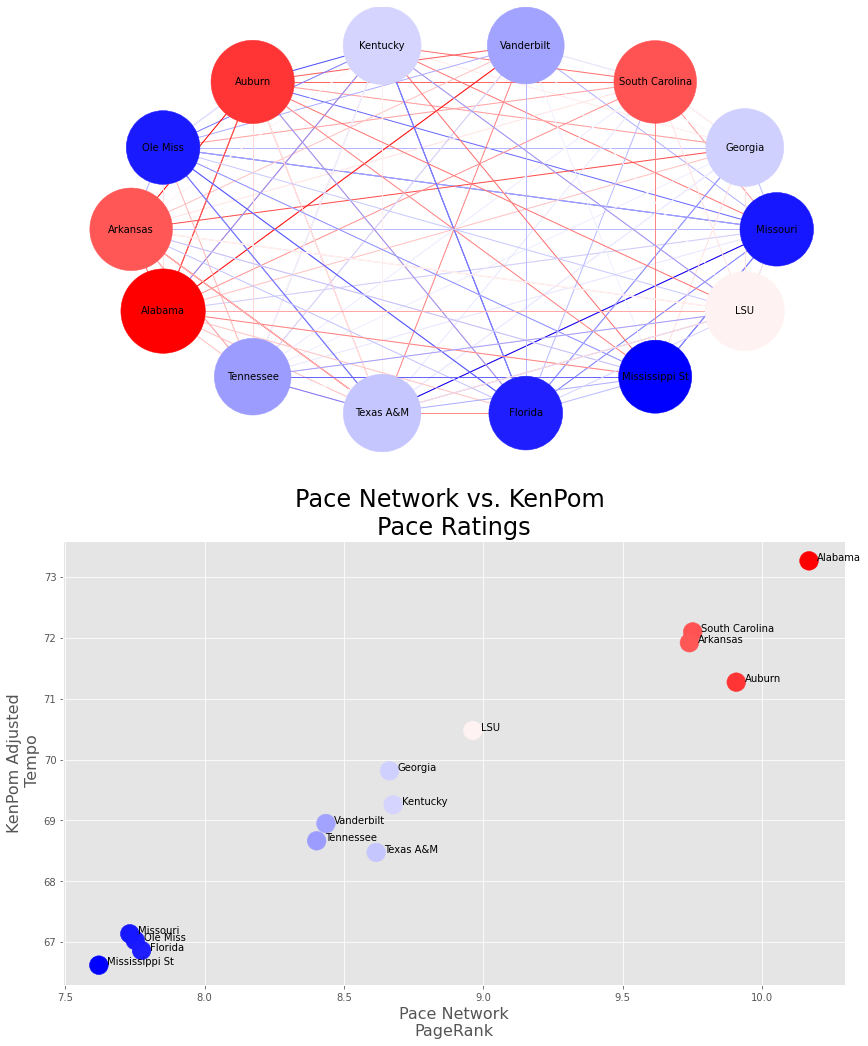

In [38]:

plt.style.use('ggplot')
def draw_pace_subgraph(pace_df, conf):
    
    # pace_series
    subteams = pace_df.copy().loc[pace_df['conference_name']==conf].reset_index(drop=True)
    prnk = pace_df.copy().set_index('team_id').to_dict()['pace_rating']
    subnodes = list(subteams['team_id'].unique())

    sub_g = pace_network.subgraph([str(sn) for sn in subnodes])

    fig, axes= plt.subplots(2,1, figsize=(14, 18))
    ax1 = axes[0]
    sub_wedges = sub_g.edges(data="weight")
    sub_edges = sub_g.edges()
    sub_nodes = sub_g.nodes()

    pos = nx.circular_layout(sub_g)
    weights = [e * 5 for u,v,e in sub_wedges]
    colors = [team_dark[int(n)] for n in sub_nodes]
    # fig, ax = plt.subplots(figsize=(22,16))
    nx.draw(sub_g, edge_color=weights, pos=pos, labels={n:teams_id2name[int(n)] for n in sub_nodes}, 
            node_color=[prnk[int(n)] for n in sub_nodes], node_size=[7e2*prnk[int(n)] for n in sub_nodes], font_size=10, font_color="black",
           cmap=plt.cm.bwr, edge_cmap=plt.cm.bwr, ax=ax1)

    ax2=axes[1]
    ax2.set_title("Pace Network vs. KenPom \nPace Ratings",fontsize=24)
    ax2.set_xlabel("Pace Network\nPageRank", fontsize=16)
    ax2.set_ylabel("KenPom Adjusted\n Tempo", fontsize=16)
    ax2.scatter(subteams.pace_rating, subteams.Tempo, c=[prnk[int(n)] for n in subteams.team_id.values],
               cmap=plt.cm.bwr, s=350)
    n = subteams.team_name
    for i, txt in enumerate(n):
        ax2.annotate(txt, (subteams.pace_rating[i]+0.03, subteams.Tempo[i]))

    plt.show()
    
    return

draw_pace_subgraph(pace_series, 'SEC')



In [185]:


pace_series.loc[pace_series['conference_name']=='ACC']


,team_id,team_name,pace_rating,pace_rank,ESPN_conference_id,conference_name,kenpom_name,Tempo,AdjTempo,RankTempo,RankAdjTempo
51,154,Wake Forest,9.508312,52.0,2,ACC,Wake Forest,71.3000,70.6110,41,30
67,153,North Carolina,9.213017,68.0,2,ACC,North Carolina,70.3015,70.2423,71,39
101,183,Syracuse,8.828515,102.0,2,ACC,Syracuse,68.4129,67.5592,159,144
139,59,Georgia Tech,8.566401,140.0,2,ACC,Georgia Tech,68.5539,68.0301,149,117
148,152,NC State,8.508052,149.0,2,ACC,N.C. State,67.8719,66.9481,188,192
156,52,Florida State,8.428749,157.0,2,ACC,Florida St.,68.6182,67.7820,142,129
187,150,Duke,8.166563,188.0,2,ACC,Duke,68.1484,67.2666,171,172
218,2390,Miami,7.925509,219.0,2,ACC,Miami FL,67.8876,67.7186,185,134
228,97,Louisville,7.880956,229.0,2,ACC,Louisville,67.5201,67.0408,206,188
280,87,Notre Dame,7.457625,281.0,2,ACC,Notre Dame,65.7995,65.6431,295,258


In [44]:

pbox


,athlete_display_name,team_short_display_name,min,fg,fg3,ft,oreb,dreb,reb,ast,...,to_pm,pf_pm,player_possessions,pts_pp,reb_pp,ast_pp,stl_pp,blk_pp,to_pp,pf_pp
0,Kris Murray,Iowa,26,5-10,2-4,0-0,0,4,4,0,...,0.038462,0.153846,24.20600,0.495745,0.165248,0.000000,0.041312,0.0,0.041312,0.165248
1,Patrick McCaffery,Iowa,28,4-13,0-4,7-10,0,5,5,3,...,0.000000,0.071429,26.06800,0.575418,0.191806,0.115084,0.000000,0.0,0.000000,0.076722
2,Filip Rebraca,Iowa,20,1-2,0-0,1-2,0,1,1,0,...,0.000000,0.250000,18.62000,0.161117,0.053706,0.000000,0.000000,0.0,0.000000,0.268528
3,Joe Toussaint,Iowa,16,3-4,1-1,0-0,0,2,2,4,...,0.062500,0.187500,14.89600,0.469925,0.134264,0.268528,0.067132,0.0,0.067132,0.201396
4,Jordan Bohannon,Iowa,22,2-5,0-2,0-0,0,1,1,1,...,0.045455,0.090909,20.48200,0.195293,0.048823,0.048823,0.000000,0.0,0.048823,0.097647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120089,Dre Marin,Southern Utah,32,3-6,2-4,0-0,0,2,2,1,...,0.062500,0.093750,26.26400,0.304599,0.076150,0.038075,0.038075,0.0,0.076150,0.114225
120090,Nick Fleming,Southern Utah,12,1-3,1-3,0-0,0,1,1,1,...,0.166667,0.333333,9.84900,0.304599,0.101533,0.101533,0.000000,0.0,0.203066,0.406133
120091,Dee Barnes,Southern Utah,0,0-0,0-0,0-0,0,0,0,0,...,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120092,Marquis Moore,Southern Utah,15,5-7,4-6,1-3,0,2,2,0,...,0.000000,0.066667,12.31125,1.218398,0.162453,0.000000,0.000000,0.0,0.000000,0.081227


In [187]:

prnk[153]


0.003593076676290568

In [41]:


# nx.draw(pace_network)
